<a href="https://colab.research.google.com/github/rawat999/Car_Segmentation/blob/master/Car_Segmentation_with_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Jul 21 11:03:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Downloading and Extrating the car dataset folder

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
import zipfile

path = '/content/gdrive/MyDrive/Car_Segmentation/carvana_dataset.zip'
zip_file = zipfile.ZipFile(path)
zip_file.extractall('/content/')
zip_file.close()

In [4]:
total_train_images = len(os.listdir('/content/Car/train/images/'))
total_train_masks = len(os.listdir('/content/Car/train/masks/'))
total_val_images = len(os.listdir('/content/Car/val/images/'))
total_val_masks = len(os.listdir('/content/Car/val/masks/'))

print("Summary: \nTotal {} training images and {} training masks.\nTotal {} validation images and {} validation masks.".format(total_train_images, 
                                                                                                                               total_train_masks,
                                                                                                                               total_val_images,
                                                                                                                               total_val_masks))

Summary: 
Total 4611 training images and 4611 training masks.
Total 477 validation images and 477 validation masks.


#### **TF Data Pipeline**

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [6]:
root = '/content/'
dataset_path = root + 'Car/'
training_data = dataset_path + 'train/'
validation_data = dataset_path + 'val/'

##### Reading images and resize to target size

In [7]:
def parse_image(img_path: str) -> dict:
  image = tf.io.read_file(img_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

  mask_path = tf.strings.regex_replace(img_path, pattern='/images/', rewrite='/masks/')
  mask_path = tf.strings.regex_replace(mask_path, pattern='.jpg',rewrite='_mask.gif')
  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_gif(mask)
  m1, m2, m3 = tf.split(mask, num_or_size_splits=3, axis=-1)
  m1 = tf.image.resize(m1[0], (IMG_SIZE, IMG_SIZE))
  m1 = tf.where(m1<=127, 0.0, m1)
  m1 = tf.where(m1>127, 1.0, m1)

  return {'image': image,'mask': m1}

In [8]:
IMG_SIZE = 224
BATCH_SIZE = 32
BUFFER_SIZE = 1000

train_dataset = tf.data.Dataset.list_files(training_data + 'images/' + '*.jpg', shuffle=True)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(validation_data + 'images/' + '*.jpg', shuffle=True)
val_dataset = val_dataset.map(parse_image)

##### Image augmentation

In [11]:
def load_image_train_with_augmentation(datapoint: dict) -> tuple:
  input_image = datapoint['image']
  input_mask = datapoint['mask']

  # left right flipping
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  # center crop
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.central_crop(input_image,0.75)
    input_mask = tf.image.central_crop(input_mask,0.75)

  # 90 degree rotation
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.rot90(input_image,k = 1)
    input_mask = tf.image.rot90(input_mask, k = 1)

  # 270 degree rotation
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.rot90(input_image,k = 3)
    input_mask = tf.image.rot90(input_mask, k = 3)

  # random brightness
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.random_brightness(input_image, 0.5)
    input_image = tf.where(input_image < 0.0, 0.0,input_image)
    input_image = tf.where(input_image > 1.0, 1.0,input_image)

  # random contrast
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.random_contrast(input_image,0.1,0.5)

  # random hue
  if tf.random.uniform(()) > 0.75:
    input_image = tf.image.random_hue(input_image, 0.3)
    input_image = tf.where(input_image < 0.0, 0.0,input_image)
    input_image = tf.where(input_image > 1.0, 1.0,input_image)

  input_image = tf.image.resize(input_image, (IMG_SIZE, IMG_SIZE))
  input_mask = tf.image.resize(input_mask, (IMG_SIZE, IMG_SIZE))
  input_mask = tf.cast(input_mask,dtype=tf.uint8)

  return {'image': input_image}, {'mask': input_mask}


def load_image_val(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['mask'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.cast(input_mask,dtype=tf.uint8)

    return {'image': input_image}, {'mask': input_mask}

In [12]:
dataset = {"train": train_dataset, "val": val_dataset}

#Train Dataset
dataset['train'] = dataset['train'].map(load_image_train_with_augmentation, 
                                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=42)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#Validation Dataset
dataset['val'] = dataset['val'].map(load_image_val)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])

<PrefetchDataset shapes: ({image: (None, 224, 224, 3)}, {mask: (None, 224, 224, 1)}), types: ({image: tf.float32}, {mask: tf.uint8})>
<PrefetchDataset shapes: ({image: (None, 224, 224, 3)}, {mask: (None, 224, 224, 1)}), types: ({image: tf.float32}, {mask: tf.uint8})>


##### Output of input pipeline

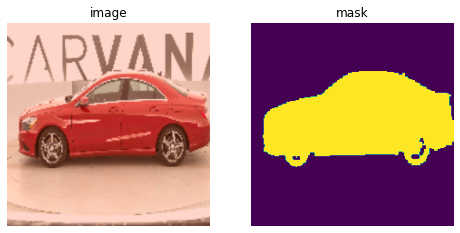

In [15]:
def display_sample(display_list,label_list):
    plt.figure(figsize=(8, 8))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title('{}'.format(label_list[i%2]))
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        print()
        plt.axis('off')
    plt.show()

for input, output in dataset['train'].take(1):
    sample_image, sample_label = input['image'], output['mask']
display_sample([sample_image[0], sample_label[0]], ['image', 'mask'])

#### **Model Building and Training**

##### MobileNetV2 as Encoder

In [42]:
from tensorflow.keras.applications import MobileNetV2

In [43]:
base_model = MobileNetV2(input_shape=(224,224,3),weights = 'imagenet',include_top=False)

# Use the activations of these layers
layer_names = [
               'block_1_expand_relu',   # 112*112
               'block_3_expand_relu',   # 56*56
               'block_6_expand_relu',   # 28*28
               'block_13_expand_relu',  # 14*14
               'out_relu',     # 7*7
               ]

layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_sampling = tf.keras.Model(inputs=base_model.input, outputs=layers,name = 'MobileNetV2')

##### Pix2Pix similar architecture as Decoder

In [44]:
# create upsampling network
initializer = tf.initializers.HeNormal()
# 7x7 -> 14x14
up_sampling1 = tf.keras.Sequential()
up_sampling1.add(tf.keras.layers.Conv2DTranspose(576,3,
                                                 strides=2,padding='same',
                                                 kernel_initializer=initializer,use_bias=False))
up_sampling1.add(tf.keras.layers.BatchNormalization())
up_sampling1.add(tf.keras.layers.ReLU())

conv1 = tf.keras.Sequential(name= 'conv1')
conv1.add(tf.keras.layers.Conv2D(64,3,padding='same',kernel_initializer=initializer))
conv1.add(tf.keras.layers.BatchNormalization())
conv1.add(tf.keras.layers.ReLU())


# 14x14 -> 28x28
up_sampling2 = tf.keras.Sequential()
up_sampling2.add(tf.keras.layers.Conv2DTranspose(192,3,
                                                 strides=2,padding='same',
                                                 kernel_initializer=initializer,use_bias=False))
up_sampling2.add(tf.keras.layers.BatchNormalization())
up_sampling2.add(tf.keras.layers.ReLU())

conv2 = tf.keras.Sequential(name= 'conv2')
conv2.add(tf.keras.layers.Conv2D(64,3,padding='same',kernel_initializer=initializer))
conv2.add(tf.keras.layers.BatchNormalization())
conv2.add(tf.keras.layers.ReLU())

# 28x28 -> 56x56
up_sampling3 = tf.keras.Sequential()
up_sampling3.add(tf.keras.layers.Conv2DTranspose(144,3,
                                                 strides=2,padding='same',
                                                 kernel_initializer=initializer,use_bias=False))
up_sampling3.add(tf.keras.layers.BatchNormalization())
up_sampling3.add(tf.keras.layers.ReLU())

conv3 = tf.keras.Sequential(name= 'conv3')
conv3.add(tf.keras.layers.Conv2D(32,3,padding='same',kernel_initializer=initializer))
conv3.add(tf.keras.layers.BatchNormalization())
conv3.add(tf.keras.layers.ReLU())

# 56x56 -> 112x112
up_sampling4 = tf.keras.Sequential()
up_sampling4.add(tf.keras.layers.Conv2DTranspose(96,3,
                                                 strides=2,padding='same',
                                                 kernel_initializer=initializer,use_bias=False))
up_sampling4.add(tf.keras.layers.BatchNormalization())
up_sampling4.add(tf.keras.layers.ReLU())

conv4 = tf.keras.Sequential(name= 'conv4')
conv4.add(tf.keras.layers.Conv2D(32,3,padding='same',kernel_initializer=initializer))
conv4.add(tf.keras.layers.BatchNormalization())
conv4.add(tf.keras.layers.ReLU())

# combine them till before the last layer
up_sampling = [up_sampling1, up_sampling2, up_sampling3, up_sampling4]
convolution = [conv1, conv2, conv3, conv4]

##### Combined Encoder+Decoder like UNet Architecture

In [45]:
def classfier_segementation():
  # Now combine the downsampling and upsampling network
  inputs = tf.keras.layers.Input(shape=[224,224,3], name='image')
  x = inputs

  # Downsampling through the model
  skips = down_sampling(x)

  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip, conv2d in zip(up_sampling, skips, convolution):
    x = up(x)
    x = tf.keras.layers.Add()([x, skip])
    x = conv2d(x)


  # This is the last layer of the segmentation model
  x = tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x)  #112*112 -> 224*224
  x = tf.keras.layers.Conv2D(1, 3, 1, padding='same', activation='sigmoid',name='mask')(x)

  return tf.keras.Model(inputs=inputs, outputs=x, name='Car_Segmentation')

Model Summary

In [46]:
model = classfier_segementation()
model.summary()

Model: "Car_Segmentation"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
MobileNetV2 (Functional)        [(None, 112, 112, 96 2257984     image[0][0]                      
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 14, 14, 576)  6637824     MobileNetV2[0][4]                
__________________________________________________________________________________________________
add_8 (Add)                     (None, 14, 14, 576)  0           sequential_8[0][0]               
                                                                 MobileNetV2[0][3] 

Network Plot

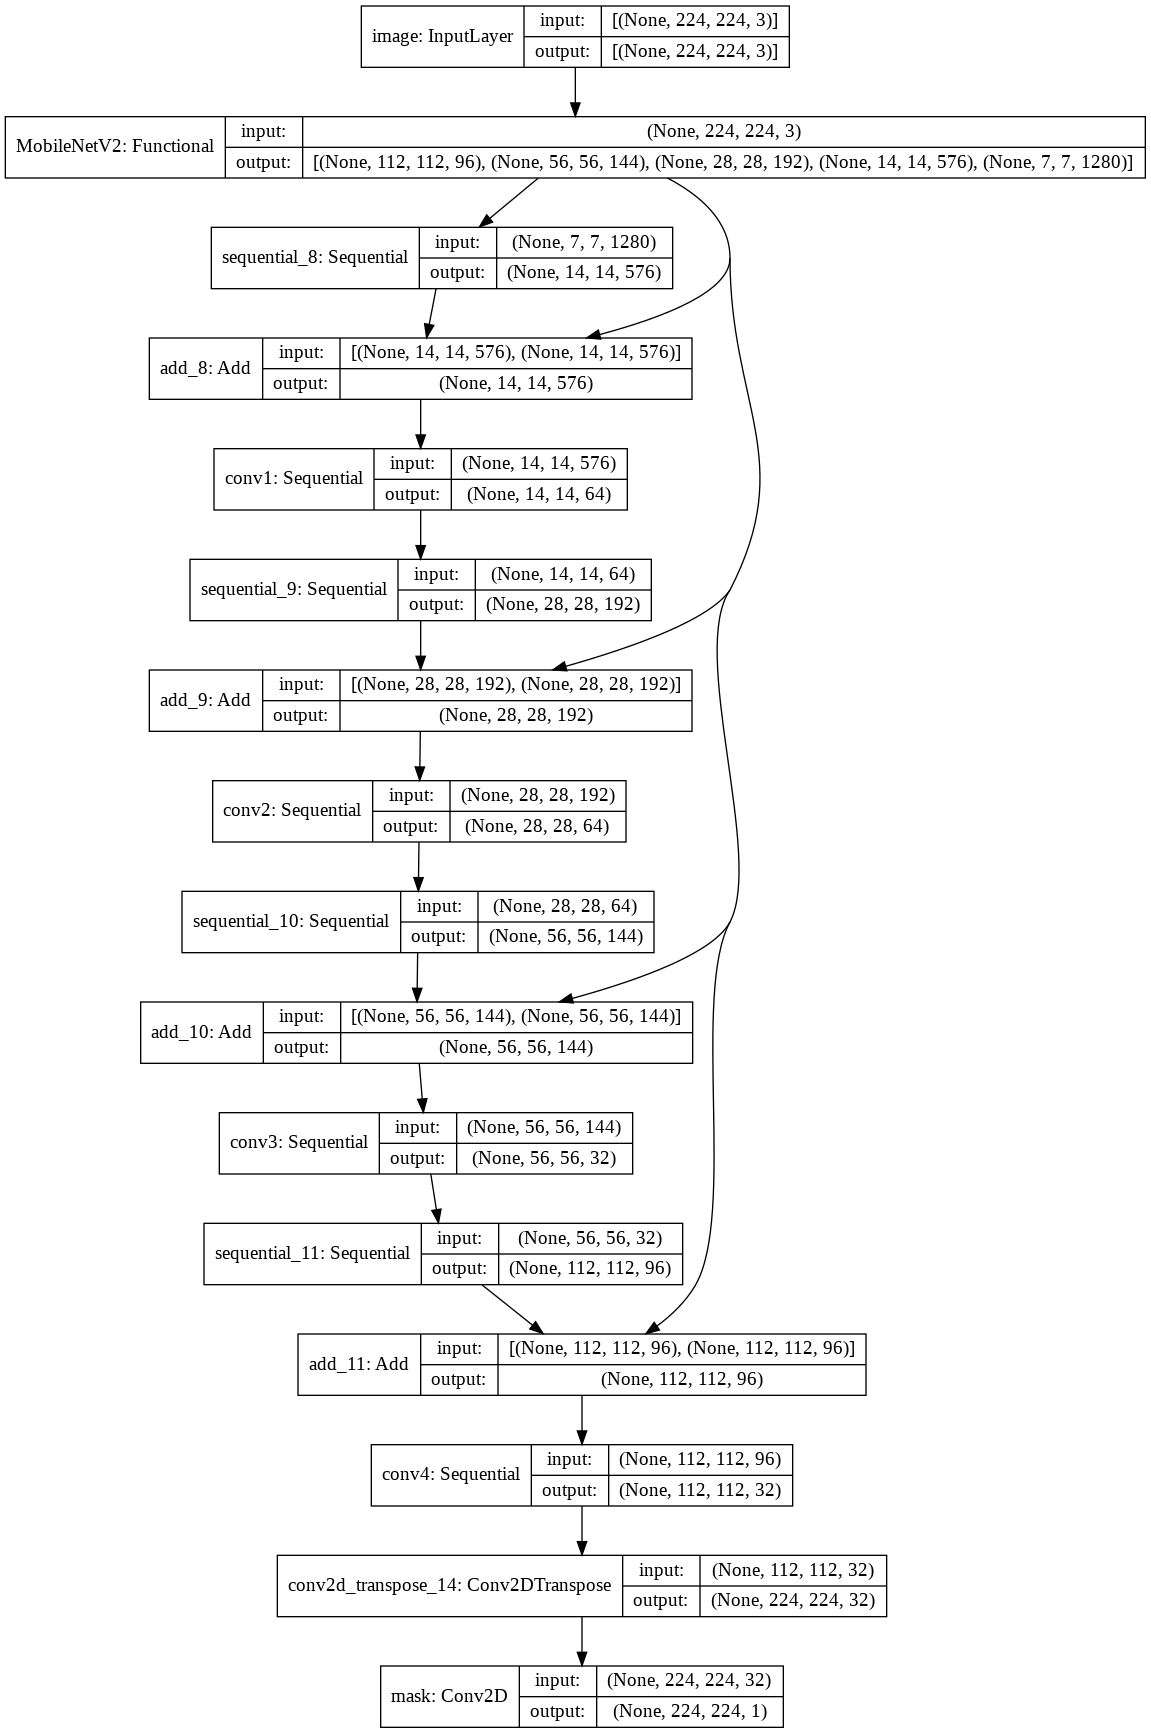

In [47]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

##### **Mean-Intersection-over-Union** <br>
Mean Intersection-Over-Union is a common evaluation metric for semantic image segmentation, which first computes the IOU for each semantic class and then computes the average over classes. IOU is defined as follows: IOU = true_positive / (true_positive + false_positive + false_negative).

In [48]:
class MyMeanIoU(tf.keras.metrics.MeanIoU):
  def update_state(self, y_true, y_pred, sample_weight = None):
    y_pred = tf.where(y_pred <= 0.5, 0.0, y_pred)
    y_pred = tf.where(y_pred > 0.5, 1.0, y_pred)
    return super().update_state(y_true, y_pred, sample_weight)

MeanIoU = MyMeanIoU(num_classes=2, name='MeanIoU')

##### Define Callbacks

In [49]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

class mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('val_loss') > logs.get('loss') and epoch >= 3):
      print("\nValidation Loss become greater than training loss. So cancelling training!")
      self.model.stop_training = True

high_val_loss = mycallback()

##### Define Model Compilation<br>
Setting up optimizer, loss and metrics which we want to use.

In [50]:
# Defined Compilation of the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=7e-06),
              loss = {'mask': tf.keras.losses.MeanAbsoluteError()},
              metrics = {'mask' : [MeanIoU]})

##### Start the Training <br>
Set up training and validation dataset. epochs, steps_per_epoch and validation_steps.

In [51]:
model_history = model.fit(dataset['train'], epochs=50,
                          validation_data = dataset['val'],
                          steps_per_epoch = total_train_images // BATCH_SIZE,
                          validation_steps = total_val_images // BATCH_SIZE,
                          callbacks=[early_stop, high_val_loss]
                          )

Epoch 1/50
144/144 [==============================] - 241s 1s/step - loss: 0.4685 - MeanIoU: 0.4153 - val_loss: 0.4448 - val_MeanIoU: 0.5571
Epoch 2/50
144/144 [==============================] - 197s 1s/step - loss: 0.3941 - MeanIoU: 0.6165 - val_loss: 0.3636 - val_MeanIoU: 0.7309
Epoch 3/50
144/144 [==============================] - 198s 1s/step - loss: 0.2987 - MeanIoU: 0.8129 - val_loss: 0.2513 - val_MeanIoU: 0.8470
Epoch 4/50
144/144 [==============================] - 208s 1s/step - loss: 0.2203 - MeanIoU: 0.8890 - val_loss: 0.1829 - val_MeanIoU: 0.8961
Epoch 5/50
144/144 [==============================] - 191s 1s/step - loss: 0.1659 - MeanIoU: 0.9184 - val_loss: 0.1390 - val_MeanIoU: 0.9199
Epoch 6/50
144/144 [==============================] - 200s 1s/step - loss: 0.1278 - MeanIoU: 0.9340 - val_loss: 0.1143 - val_MeanIoU: 0.9176
Epoch 7/50
144/144 [==============================] - 187s 1s/step - loss: 0.1007 - MeanIoU: 0.9416 - val_loss: 0.0947 - val_MeanIoU: 0.9214
Epoch 8/50
14

##### Training & Validation Loss Curve

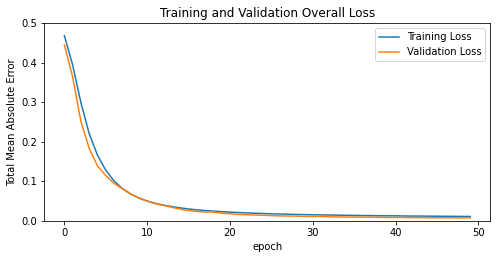

In [52]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Total Mean Absolute Error')
plt.ylim([0.0,0.5])
plt.title('Training and Validation Overall Loss')
plt.xlabel('epoch')
plt.show()

##### Training & validation MeanIoU Curve

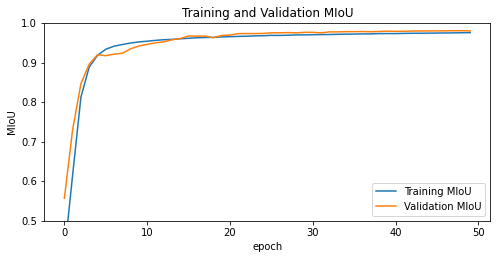

In [53]:
train_miou = model_history.history['MeanIoU']
val_miou = model_history.history['val_MeanIoU']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 2)
plt.plot(train_miou, label='Training MIoU')
plt.plot(val_miou, label='Validation MIoU')
plt.legend(loc='lower right')
plt.ylabel('MIoU')
plt.ylim([0.5,1])
plt.title('Training and Validation MIoU')
plt.xlabel('epoch')
plt.show()

**Conclusion**
Here, I got 98.09% Mean-Intersection-over-Union on validation set after 50 epochs. Still there is chance of increase in validation MeanIoU in further training.

In [ ]:
#model.save('/content/gdrive/MyDrive/Car_Segmentation/trained_model/car_segment_augment.h5', include_optimizer=False)

In [55]:
#model.save_weights('/content/gdrive/MyDrive/Car_Segmentation/trained_model_weights/car_segment_augment.h5')